# 輸入套件

In [1]:
# 自製模組套件
from preprocess import Data
from backtest import Backtest

# 外部套件
import os
from operators import lag

# 輸入資料

In [2]:
# 檢視可使用資料
os.listdir('data')

['benchmark.csv',
 'close_price.csv',
 'market_size.csv',
 'open_price.csv',
 'vol.csv',
 '單月合併營收創N個月新高_已格式化.csv',
 '單月合併營收年成長(%)連N個月大於零_已格式化.csv',
 '單月合併營收連N個月遞增_已格式化.csv',
 '單月營收年成長(%)_已格式化.csv',
 '收盤價_未還原_已格式化.csv',
 '累計合併營收成長(%)連N個月大於零_已格式化.csv']

In [3]:
# 建立Data物件
vol = Data(
    data_name='vol',
    data_frequency='day',
    market_size_threshold=None,
    market_size_select_rank='top',
    market_size_select_number=200
)

close_price = Data(
    data_name='close_price',
    data_frequency='day',
    market_size_select_rank='top',
    market_size_select_number=200
)

# 定義篩選條件、計算公式

In [4]:
# 建立濾網
def smaller_than_point_3(series):
    '''
    回傳小於0.3者
    '''
    return series <= 0.3

# 建立運算function
def calculate_days_20_return(series):
    '''
    計算近20日報酬
    '''
    return (
        series / lag(series, 20) -1
    )

# 建立濾網
def bigger_than_0(series):
    '''
    回傳大於0者
    '''
    return series > 0

# 加入篩選條件、計算自定義數值分析
範例策略：每月最後一日衡量，波動度小於0.3者，取近20日報酬前30%之個股。

In [5]:
# 將資料縮減至給定頻率
vol.mutate_data(
    None, 
    rebalance_frequency='month',
    date_order_ascending=False,
    measure_on_nth_date=1
)

# 將資料進行運算，同時縮減至給定頻率
close_price.mutate_data(
    calculate_days_20_return,
    rebalance_frequency='month',
    date_order_ascending=False,
    measure_on_nth_date=1
)

出場衡量 - '每月最後1個交易日進行再平衡衡量(於下一個交易日出場)' 已指定!
 
資料修改 - 'close_price' 已完成!
出場衡量 - '每月最後1個交易日進行再平衡衡量(於下一個交易日出場)' 已指定!
 


In [6]:
# 選擇波動度小於0.3
vol.add_filter(smaller_than_point_3)

篩選條件 - 'smaller_than_point_3' 已新增!
市值資料可能需要更新！
Error: Timestamp('2019-07-31 00:00:00')
 
市值條件 - 'top 200' 名已選擇！
 


In [7]:
# 通過波動度小於0.3者接著找出近20日報酬大於0者
vol.pipe_to(close_price).select(rank='top', number=30)

市值條件 - 'top 200' 名已選擇！
 
'vol' 之訊號已成功傳遞至 'close_price'
close_price - 'top 30' 名已選擇!



# 開始回測

In [8]:
# 此時close_price以帶有vol的訊號，因此只需要輸入close_price即可
signal_list = [
    close_price
]

backtesting = Backtest(
    signal_list,
    report_mode=False,
    start_date='2010/1/1',
    end_date='2019/6/30',
    long_or_short='long'
)
backtesting.run()

Progress: 100% |#######################| Elapsed Time: 0:00:09 , Time: 0:00:09 


# 分析結果

In [9]:
from analysis import Analysis

backtesting_result = Analysis(backtesting)
backtesting_result.run()

Progress: 100% |#######################| Elapsed Time: 0:00:58 , Time: 0:00:58 


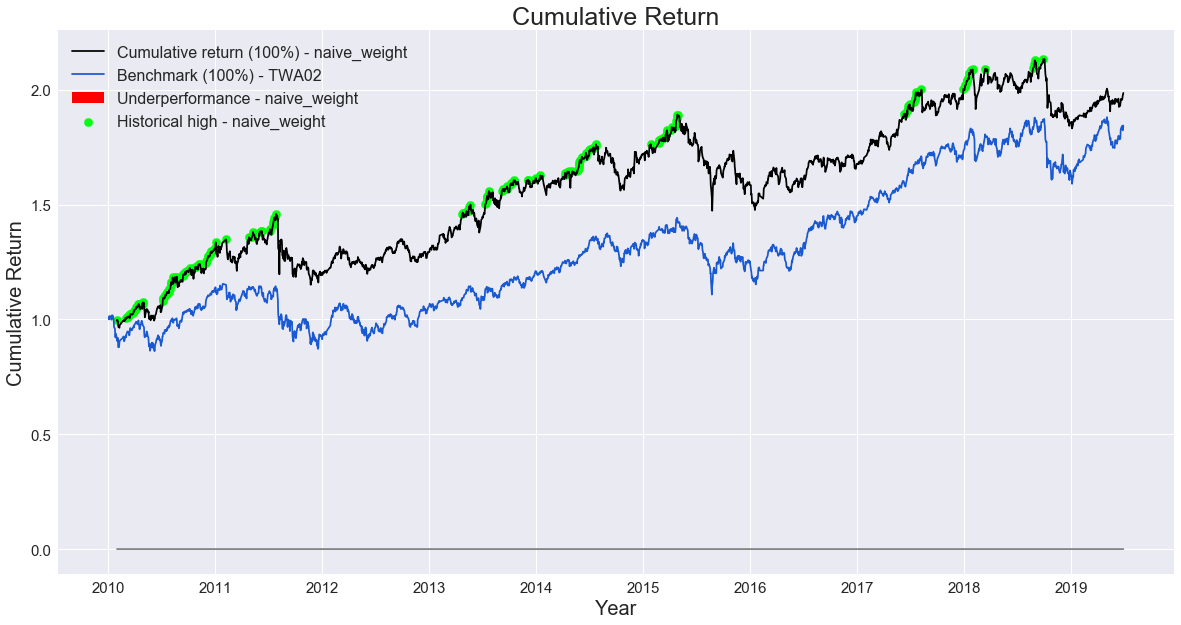

In [10]:
backtesting_result.plot_cumulative_return(weight_method='naive_weight')

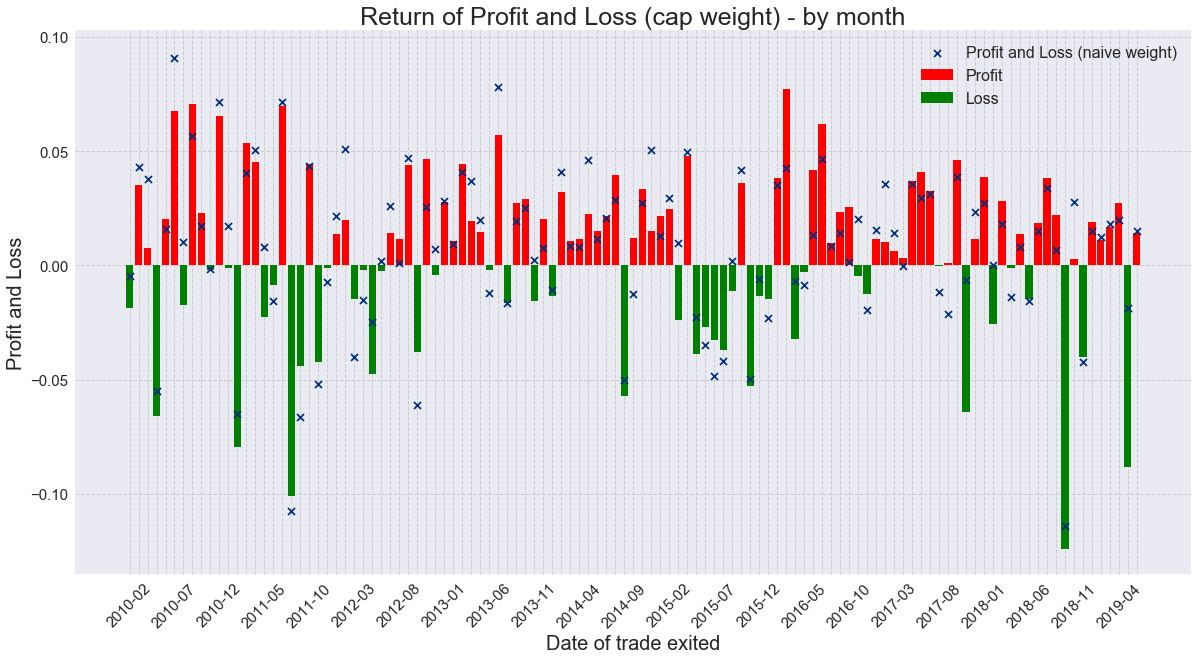

In [11]:
backtesting_result.plot_profit_and_loss(weight_method='cap_weight')

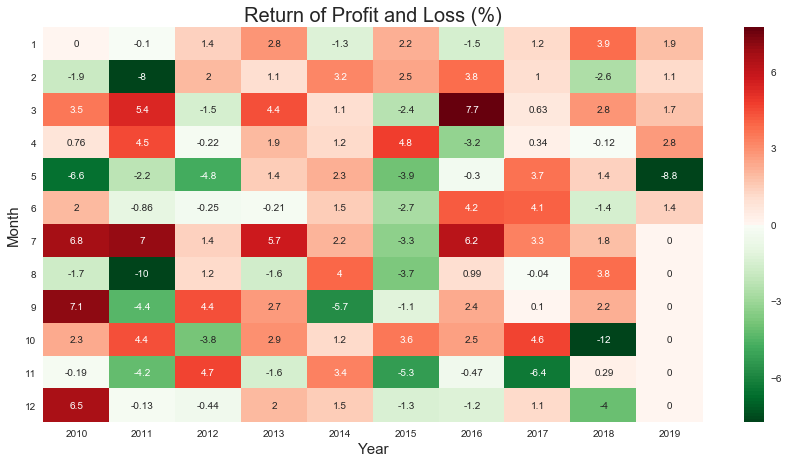

In [12]:
backtesting_result.plot_return_heatmap(weight_method='cap_weight')

In [13]:
backtesting_result.summary()

=========================================  ===========  ==============  ============
Backtesting result                         Benchmark    Naive weight    Cap weight
=========================================  ===========  ==============  ============
Start date                                 2010/01/01   2010/01/01      2010/01/01
End date                                   2019/06/30   2019/06/30      2019/06/30
Duration (years)                           9.5          9.5             9.5
Total trade                                NA           3348            3348
Total entry times                          NA           113             113
Average trade number per entry             NA           29.63           29.63
Average holding days                       NA           30              30
Cumulative return                          83.67%       98.56%          64.38%
Annual return                              7.58%        8.38%           6.52%
CAGR                                      